<a href="https://colab.research.google.com/github/Firojpaudel/Deepseek_implementation_scratch/blob/main/MHA_MQA_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@ Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MHA(nn.Module):
    """Lightweight Multi-Head Attention model."""
    def __init__(self, d_model, num_heads, num_layers=1, head_dim=None):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = head_dim or d_model // num_heads
        self.num_layers = num_layers
        self.q_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.k_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.v_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.out_projs = nn.ModuleList([nn.Linear(num_heads * self.head_dim, d_model, bias=False) for _ in range(num_layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_layers)])

    def forward(self, x, cache=None):
        b, tgt_len, _ = x.shape
        if cache is None:
            cache = [None] * self.num_layers
        new_cache = []
        for i in range(self.num_layers):
            residual = x
            x_norm = self.norms[i](x)
            q = self.q_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)  # b n tgt_len h
            if cache[i] is None:
                k = self.k_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                v = self.v_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                ck, cv = k, v
            else:
                ck, cv = cache[i]
                k_new = self.k_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                v_new = self.v_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                ck = torch.cat([ck, k_new], dim=2)
                cv = torch.cat([cv, v_new], dim=2)
            attn_output = F.scaled_dot_product_attention(q, ck, cv)
            attn_output = attn_output.transpose(1, 2).contiguous().view(b, tgt_len, -1)
            x = residual + self.out_projs[i](attn_output)
            new_cache.append((ck, cv))
        return x, new_cache

class MQA(nn.Module):
    """Lightweight Multi-Query Attention model (shared KV heads)."""
    def __init__(self, d_model, num_heads, num_layers=1, head_dim=None):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = head_dim or d_model // num_heads
        self.num_layers = num_layers
        self.num_kv_heads = 1
        self.q_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.k_projs = nn.ModuleList([nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.v_projs = nn.ModuleList([nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.out_projs = nn.ModuleList([nn.Linear(num_heads * self.head_dim, d_model, bias=False) for _ in range(num_layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_layers)])

    def forward(self, x, cache=None):
        b, tgt_len, _ = x.shape
        if cache is None:
            cache = [None] * self.num_layers
        new_cache = []
        for i in range(self.num_layers):
            residual = x
            x_norm = self.norms[i](x)
            q = self.q_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)  # b n tgt_len h
            if cache[i] is None:
                k = self.k_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                v = self.v_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                ck, cv = k, v
            else:
                ck, cv = cache[i]
                k_new = self.k_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                v_new = self.v_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                ck = torch.cat([ck, k_new], dim=2)
                cv = torch.cat([cv, v_new], dim=2)
            # Repeat KV to match num_heads
            k_repeated = ck.repeat(1, self.num_heads, 1, 1)
            v_repeated = cv.repeat(1, self.num_heads, 1, 1)
            attn_output = F.scaled_dot_product_attention(q, k_repeated, v_repeated)
            attn_output = attn_output.transpose(1, 2).contiguous().view(b, tgt_len, -1)
            x = residual + self.out_projs[i](attn_output)
            new_cache.append((ck, cv))
        return x, new_cache

def get_cache_size(cache):
    """Compute total bytes in KV cache."""
    total_bytes = 0
    for layer_cache in cache:
        k, v = layer_cache
        total_bytes += (k.numel() + v.numel()) * k.element_size()
    return total_bytes

In [3]:
# Config (lightest models)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
d_model = 128
num_heads = 8
head_dim = d_model // num_heads
num_layers = 2
b = 1
max_s = 1024  # Max sequence length for generation sim

mha_model = MHA(d_model, num_heads, num_layers, head_dim).to(device)
mqa_model = MQA(d_model, num_heads, num_layers, head_dim).to(device)

In [4]:
# Model param memory
mha_params_bytes = sum(p.numel() * p.element_size() for p in mha_model.parameters())
mqa_params_bytes = sum(p.numel() * p.element_size() for p in mqa_model.parameters())
print(f"MHA model params memory: {mha_params_bytes} bytes (~{mha_params_bytes / 1024 / 1024:.2f} MB)")
print(f"MQA model params memory: {mqa_params_bytes} bytes (~{mqa_params_bytes / 1024 / 1024:.2f} MB)")

# Simulate generation and measure KV cache
print("\nseq_len | MHA KV bytes | MQA KV bytes")
print("--------|--------------|--------------")
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()  # Uncomment for peak GPU tracking

mha_cache = None
mqa_cache = None
mha_sizes, mqa_sizes = [], []
for pos in range(1, max_s + 1):
    x = torch.randn(b, 1, d_model, device=device)
    _, mha_cache = mha_model(x, mha_cache)
    _, mqa_cache = mqa_model(x, mqa_cache)
    mha_size = get_cache_size(mha_cache)
    mqa_size = get_cache_size(mqa_cache)
    mha_sizes.append(mha_size)
    mqa_sizes.append(mqa_size)
    if pos % 100 == 0 or pos <= 10:  # Print every 100 + first 10
        print(f"{pos:7d} | {mha_size:12d} | {mqa_size:11d}")

MHA model params memory: 526336 bytes (~0.50 MB)
MQA model params memory: 296960 bytes (~0.28 MB)

seq_len | MHA KV bytes | MQA KV bytes
--------|--------------|--------------
      1 |         2048 |         256
      2 |         4096 |         512
      3 |         6144 |         768
      4 |         8192 |        1024
      5 |        10240 |        1280
      6 |        12288 |        1536
      7 |        14336 |        1792
      8 |        16384 |        2048
      9 |        18432 |        2304
     10 |        20480 |        2560
    100 |       204800 |       25600
    200 |       409600 |       51200
    300 |       614400 |       76800
    400 |       819200 |      102400
    500 |      1024000 |      128000
    600 |      1228800 |      153600
    700 |      1433600 |      179200
    800 |      1638400 |      204800
    900 |      1843200 |      230400
   1000 |      2048000 |      256000



Theoretical bytes per additional token - MHA: 2048, MQA: 256
Note: Actual sizes match theoretical KV cache (excluding other memory).
Peak GPU memory (both models): 1098820096 bytes (~1047.92 MB)

Plot saved as 'mha_mqa_comparison.png'. MHA uses 8x more KV cache than MQA.


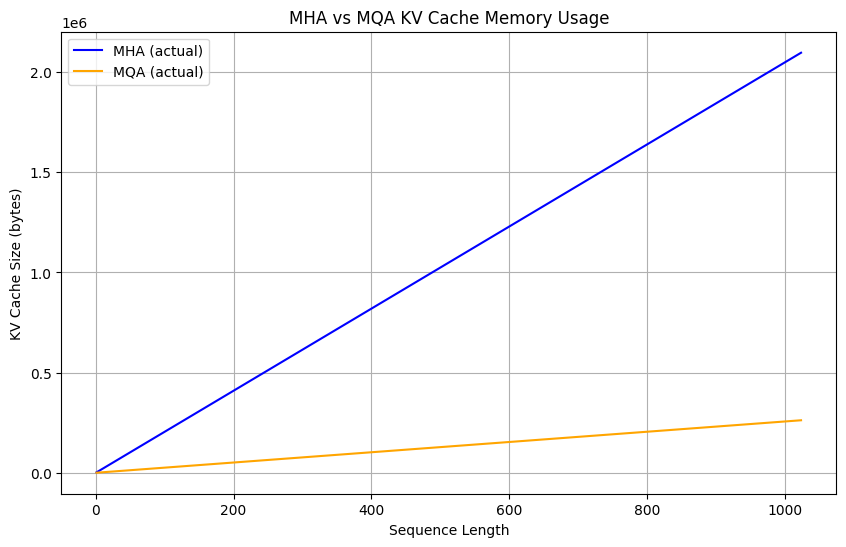

In [5]:
# Theoretical
theo_mha_per_token = num_layers * b * num_heads * head_dim * 2 * 4
theo_mqa_per_token = num_layers * b * 1 * head_dim * 2 * 4
print(f"\nTheoretical bytes per additional token - MHA: {theo_mha_per_token}, MQA: {theo_mqa_per_token}")
print("Note: Actual sizes match theoretical KV cache (excluding other memory).")

if torch.cuda.is_available():
    peak_gpu = torch.cuda.max_memory_allocated()
    print(f"Peak GPU memory (both models): {peak_gpu} bytes (~{peak_gpu / 1024 / 1024:.2f} MB)")

# Plot KV cache vs seq_len
s_list = np.arange(1, max_s + 1)
plt.figure(figsize=(10, 6))
plt.plot(s_list, mha_sizes, label='MHA (actual)', color='blue')
plt.plot(s_list, mqa_sizes, label='MQA (actual)', color='orange')
plt.xlabel('Sequence Length')
plt.ylabel('KV Cache Size (bytes)')
plt.title('MHA vs MQA KV Cache Memory Usage')
plt.legend()
plt.grid(True)
# plt.yscale('log')  # Uncomment for log scale on long seqs
plt.savefig('mha_mqa_comparison.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as 'mha_mqa_comparison.png'. MHA uses {num_heads}x more KV cache than MQA.")

Also, lets test in the real pretrained models that have MHA and MQA.

In [1]:
!pip install -qq transformers accelerate matplotlib torch

In [13]:
#@ Starting with imports once again
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
def get_valid_attentions(attentions):
    """Filter out None layers from the attentions tuple/list."""
    if attentions is None:
        return []
    return [a for a in attentions if a is not None]

def plot_heads_heatmaps(attentions, tokens, title, layer_index=-1):
    """Plot heatmaps for all heads in a given layer."""
    layer_attn = attentions[layer_index]  # [batch, heads, seq, seq]
    num_heads = layer_attn.shape[1]

    fig, axes = plt.subplots(1, num_heads, figsize=(3*num_heads, 3))
    if num_heads == 1:
        axes = [axes]

    for i in range(num_heads):
        sns.heatmap(
            layer_attn[0, i].detach().cpu().numpy(),
            xticklabels=tokens,
            yticklabels=tokens,
            cbar=False,
            ax=axes[i]
        )
        axes[i].set_title(f"Head {i}")

    fig.suptitle(f"{title} - Layer {layer_index} attention heads", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_head_variance(attentions, title):
    """Plot variance across heads for each token."""
    layer_attn = attentions[-1]  # last valid layer
    # [batch, heads, seq, seq] -> variance across heads
    variance = layer_attn.var(dim=1).mean(dim=-1).squeeze().cpu().numpy()

    plt.figure(figsize=(6,4))
    plt.plot(variance, marker="o")
    plt.title(f"{title} - Variance across heads (last layer)")
    plt.xlabel("Token index")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.show()

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


GPT-2 (MHA): 12 valid layers
Falcon (MQA): 24 valid layers


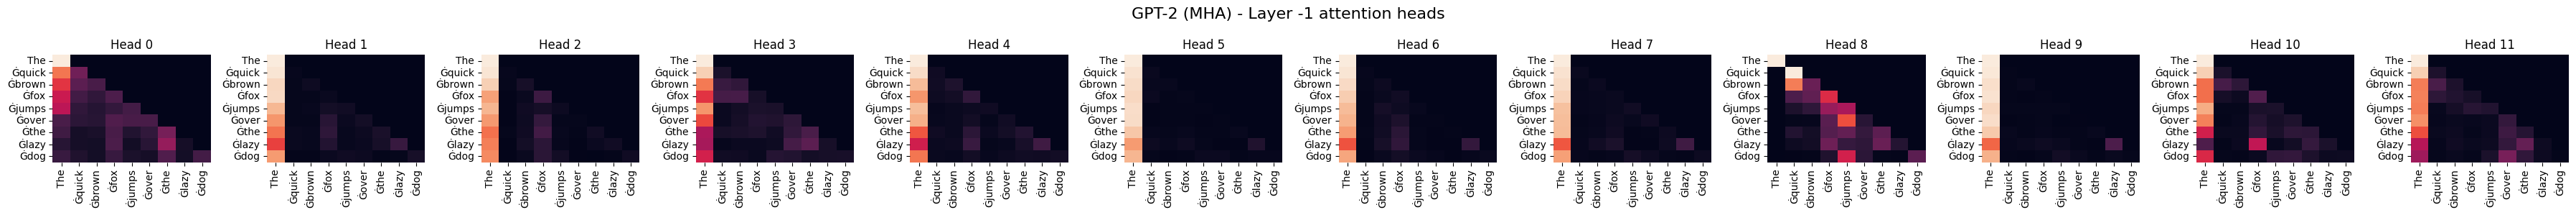

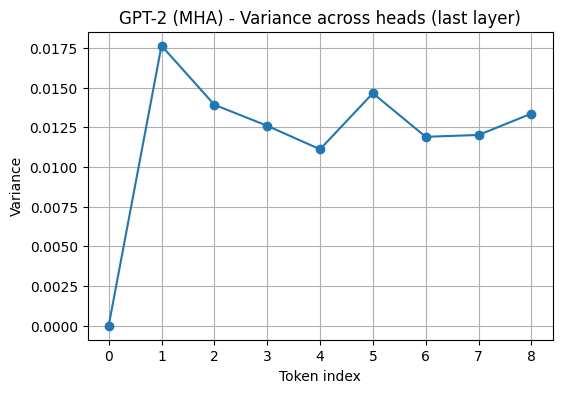

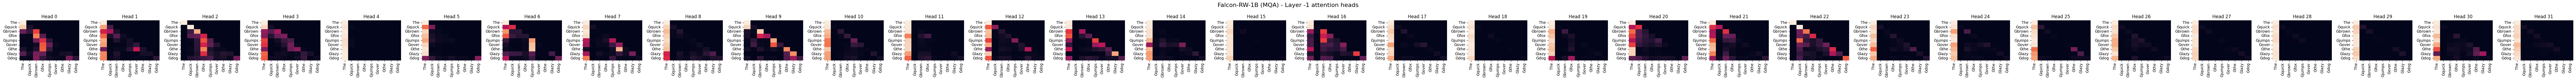

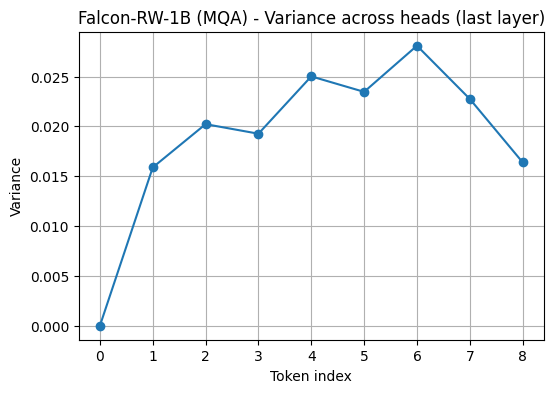

In [15]:
def main():
    text = "The quick brown fox jumps over the lazy dog"

    # ---- GPT-2 (MHA) ----
    mha_model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True)
    mha_tokenizer = AutoTokenizer.from_pretrained("gpt2")
    inputs_mha = mha_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        out_mha = mha_model(**inputs_mha, output_attentions=True)
    attn_mha = get_valid_attentions(out_mha.attentions)
    tokens_mha = mha_tokenizer.convert_ids_to_tokens(inputs_mha["input_ids"][0])

    # ---- Falcon (MQA) ----
    mqa_model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-rw-1b", trust_remote_code=True, output_attentions=True)
    mqa_tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-rw-1b")
    inputs_mqa = mqa_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        out_mqa = mqa_model(**inputs_mqa, output_attentions=True)
    attn_mqa = get_valid_attentions(out_mqa.attentions)
    tokens_mqa = mqa_tokenizer.convert_ids_to_tokens(inputs_mqa["input_ids"][0])

    print(f"GPT-2 (MHA): {len(attn_mha)} valid layers")
    print(f"Falcon (MQA): {len(attn_mqa)} valid layers")

    # ---- Plot heatmaps ----
    if attn_mha:
        plot_heads_heatmaps(attn_mha, tokens_mha, "GPT-2 (MHA)", layer_index=-1)
        plot_head_variance(attn_mha, "GPT-2 (MHA)")
    if attn_mqa:
        plot_heads_heatmaps(attn_mqa, tokens_mqa, "Falcon-RW-1B (MQA)", layer_index=-1)
        plot_head_variance(attn_mqa, "Falcon-RW-1B (MQA)")

if __name__ == "__main__":
    main()